In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

np.random.seed(0)

In [2]:
# 初始化环境并玩一步

env = gym.make('Taxi-v3')
env.seed(0)

state = env.reset()
taxirow, taxicol, passloc, destidx = env.unwrapped.decode(state)

print('出租车位置 = {}'.format((taxirow, taxicol)))
print('乘客位置 = {}'.format(env.unwrapped.locs[passloc]))
print('目标位置 = {}'.format(env.unwrapped.locs[destidx]))

env.render()
env.step(1)

出租车位置 = (0, 1)
乘客位置 = (0, 4)
目标位置 = (4, 0)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



(26, -1, False, {'prob': 1.0})

In [3]:
# SARSA算法智能体的实现

class SARSAAgent(object):
    
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        return

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, done, next_action):
        u = reward + self.gamma * self.q[next_state, next_action] * (1.0 - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error
        return

In [4]:
# SARSA智能体与环境交互一回合

def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    
    while True:
        if render:
            env.render()
        
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation)
        
        if train:
            agent.learn(observation, action, reward, next_observation, done, next_action)
        
        if done:
            break
        
        observation, action = next_observation, next_action

    return episode_reward

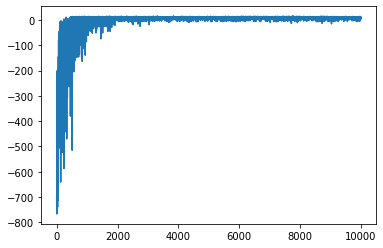

In [5]:
# 训练SARSA算法

agent = SARSAAgent(env)

episodes = 10000
episode_rewards = []
for episode in tqdm(range(episodes)):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [6]:
# 测试SARSA算法

agent.epsilon = 0.0
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = 8.11 


In [7]:
# 显示最优价值估计

pd.DataFrame(agent.q)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.028923,-3.035849,-3.473541,-3.072329,1.133675,-5.082341
2,-0.577135,-1.271961,-1.414977,-1.281007,7.172636,-3.865790
3,-2.206421,-3.008951,-3.028152,-3.405872,2.430150,-4.972073
4,-5.512732,-6.044403,-5.960489,-6.001211,-7.386889,-7.398045
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-2.515656,-2.392497,-2.393122,-1.465809,-3.764710,-3.772972
497,-1.258346,-1.006706,-1.270159,-1.141122,-1.900000,-1.909000
498,-2.360109,-2.400347,-2.441104,-2.357097,-3.764322,-4.596034


In [8]:
# 显示最优策略估计

policy = np.eye(agent.action_n)[agent.q.argmax(axis=-1)]
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,1.0,0.0,0.0
497,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# 期望SARSA算法智能体类

class ExpectedSARSAAgent(object):
    
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        return
    
    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action
    
    def learn(self, state, action, reward, next_state, done):
        v = (self.q[next_state].sum() * self.epsilon) + (self.q[next_state].max() * (1 - self.epsilon))
        u = reward + self.gamma * v * (1.0 - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error
        return

In [10]:
# 期望SARSA智能体或Q学习智能体与环境的交互

def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    
    while True:
        if render:
            env.render()
        
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        
        if train:
            agent.learn(observation, action, reward, next_observation, done)
        
        if done:
            break
        
        observation = next_observation
    
    return episode_reward

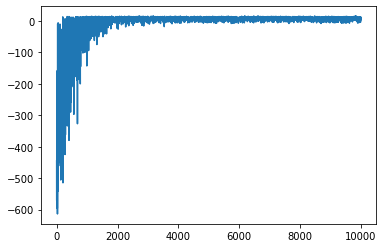

In [11]:
# 训练期望SARSA算法

agent = ExpectedSARSAAgent(env)
episodes = 10000
episode_rewards = []
for _ in tqdm(range(episodes)):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [12]:
# 测试SARSA期望算法

agent.epsilon = 0.0
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = 8.2 


In [13]:
# 显示最优价值估计

pd.DataFrame(agent.q)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.546616,-3.402425,-3.888237,-3.791648,1.483474,-3.884326
2,-0.782049,0.225822,-1.877812,-1.910723,7.940709,-2.970478
3,-3.193839,-2.355867,-2.982298,-1.662137,2.834340,-3.929468
4,-6.744610,-7.180412,-7.179502,-7.185417,-8.734758,-7.855929
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-2.840654,-2.883630,-2.887393,-2.845038,-2.984210,-2.986866
497,-0.984233,2.353218,-0.985232,-0.962715,-1.000360,-1.001261
498,-2.882060,-2.824897,-2.869106,-1.781766,-2.890102,-2.986779


In [14]:
# 显示最优策略估计

policy = np.eye(agent.action_n)[agent.q.argmax(axis=-1)]
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,1.0,0.0,0.0,0.0,0.0,0.0
497,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
# Q学习智能体

class QLearningAgent(object):
    
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        return

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, done):
        u = reward + self.gamma * self.q[next_state].max() * (1.0 - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error
        return

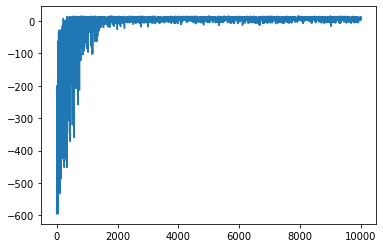

In [16]:
# 训练Q学习

agent = QLearningAgent(env)
episodes = 10000
episode_rewards = []
for _ in tqdm(range(episodes)):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [17]:
# 测试Q学习算法

agent.epsilon = 0.0
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = 8.3 


In [18]:
# 显示最优价值估计

pd.DataFrame(agent.q)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.124003,-2.991229,-3.370831,-2.649612,1.622615,-3.940399
2,-0.080703,-0.968787,-0.067255,0.903366,7.714700,-2.309564
3,-2.636116,-1.086635,-2.820413,-2.489738,2.914016,-3.410829
4,-5.207394,-5.782219,-5.751138,-5.786658,-5.813545,-6.628407
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-2.376573,-2.350526,-2.376573,-1.808516,-2.970100,-2.970100
497,-1.224790,-1.059744,-1.224790,-1.150904,-2.885196,-1.990000
498,-2.602996,-2.604053,-2.602996,-2.574521,-3.857886,-2.970100


In [19]:
# 显示最优策略估计

policy = np.eye(agent.action_n)[agent.q.argmax(axis=-1)]
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,1.0,0.0,0.0
497,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
# 双重Q学习智能体

class DoubleQLearningAgent(object):
    
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q0 = np.zeros((env.observation_space.n, env.action_space.n))
        self.q1 = np.zeros((env.observation_space.n, env.action_space.n))
        return
    
    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = (self.q0 + self.q1)[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action
    
    def learn(self, state, action, reward, next_state, done):
        if np.random.randint(2):
            self.q0, self.q1 = self.q1, self.q0
        
        a = self.q0[next_state].argmax()
        u = reward + self.gamma * self.q1[next_state, a] * (1.0 - done)
        td_error = u - self.q0[state, action]
        self.q0[state, action] += self.learning_rate * td_error
        return

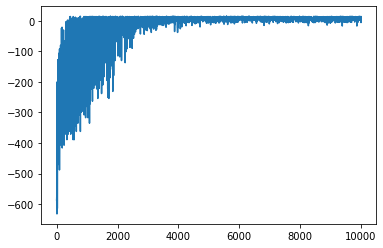

In [21]:
# 训练双重Q学习

agent = DoubleQLearningAgent(env)
episodes = 10000
episode_rewards = []
for _ in tqdm(range(episodes)):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [22]:
# 测试双重Q学习算法

agent.epsilon = 0.0
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = 7.82 


In [23]:
# 显示最优价值估计

pd.DataFrame(agent.q0)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-5.986556,-7.257732,-6.155241,-7.537594,1.622615,-5.294535
2,-1.607690,-0.673017,-1.730193,-2.230060,7.714700,-2.266588
3,-4.839421,-5.471738,-5.193619,-5.186914,2.914016,-3.735005
4,-8.957584,-10.529298,-9.707733,-10.536748,-11.144867,-10.437932
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-3.112101,-4.064573,-3.706573,-2.673362,-3.478854,-6.503041
497,-1.769100,-2.141830,-1.860535,-1.396624,-3.209281,-1.258943
498,-4.158112,-3.618051,-4.564065,-3.187294,-6.022438,-3.901597


In [24]:
# 显示最优策略估计

policy = np.eye(agent.action_n)[agent.q0.argmax(axis=-1)]
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,1.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,1.0
498,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
# SARSA(lambda)算法智能体类

class SARSALambdaAgent(SARSAAgent):
    
    def __init__(self, env, lambd=0.5, beta=1.0, gamma=0.9, learning_rate=0.1, epsilon=0.01):
        super(SARSALambdaAgent, self).__init__(env, gamma=gamma, learning_rate=learning_rate, epsilon=epsilon)
        
        self.lambd = lambd
        self.beta = beta
        self.e = np.zeros((env.observation_space.n, env.action_space.n))
        return
    
    def learn(self, state, action, reward, next_state, done, next_action):
        # 更新资格迹
        self.e *= (self.lambd * self.gamma)
        self.e[state, action] = 1.0 + self.beta * self.q[state, action]
        
        # 更新价值
        u = reward + self.gamma * self.q[next_state, next_action] * (1.0 - done)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error
        
        # 为下一回合初始化资格迹
        if done:
            self.e *= 0.0
        
        return

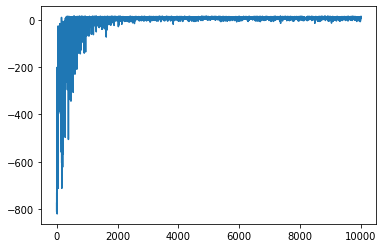

In [26]:
# 训练SARSA(lambda)

agent = SARSALambdaAgent(env)
episodes = 10000
episode_rewards = []
for _ in tqdm(range(episodes)):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [27]:
# 测试SARSA(lambda)算法

agent.epsilon = 0.0
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = 7.78 


In [28]:
# 显示最优价值估计

pd.DataFrame(agent.q)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.092646,-2.726551,-3.297556,-3.475428,0.715679,-3.668853
2,-0.939008,-1.751329,-1.488359,-1.038333,7.674337,-2.440415
3,-3.252061,-2.739684,-2.681045,-2.016779,2.676909,-4.835084
4,-5.603645,-5.700881,-5.405042,-5.662197,-6.425514,-7.398146
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-2.509851,-2.454567,-2.533311,-2.497134,-3.792000,-3.773624
497,-1.259265,-0.869824,-1.270472,-1.145631,-2.890228,-1.909000
498,-2.609590,-2.645178,-2.675197,-1.267641,-3.764405,-2.785257


In [29]:
# 显示最优策略估计

policy = np.eye(agent.action_n)[agent.q.argmax(axis=-1)]
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,0.0,1.0,0.0,0.0,0.0,0.0
497,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,1.0,0.0,0.0
